In [71]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
style.use('ggplot')

start = dt.datetime(2000,1,1)
end= dt.datetime(2016,12,31)
df= web.DataReader('TSLA','yahoo',start,end)


In [3]:
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,23.889999
2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,21.959999
2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,19.200001
2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [4]:
#to put inside csv
df.to_csv('tsla.csv')

In [9]:
# To read csv into dataframe
df = pd.read_csv('tsla.csv',parse_dates=True,index_col=0)

In [10]:
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,18766300,23.889999
2010-06-30,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2010-07-01,25.000000,25.92,20.270000,21.959999,8218800,21.959999
2010-07-02,23.000000,23.10,18.709999,19.200001,5139800,19.200001
2010-07-06,20.000000,20.00,15.830000,16.110001,6866900,16.110001


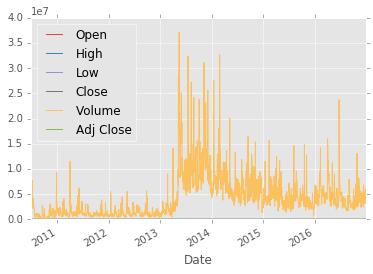

In [12]:
%matplotlib inline
df.plot()

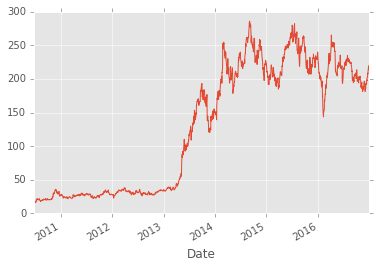

In [14]:
df['Adj Close'].plot()

In [21]:
df['100ma']=df['Adj Close'].rolling(window=100,min_periods=0).mean()

In [22]:
# df.dropna(inplace=True)
print(df.head())

                 Open       High        Low      Close   Volume  Adj Close  \
Date                                                                         
2010-11-17  30.200001  30.750000  28.610001  29.490000   750000  29.490000   
2010-11-18  30.670000  30.740000  28.920000  29.889999   956100  29.889999   
2010-11-19  30.160000  31.370001  29.700001  30.990000  1150500  30.990000   
2010-11-22  31.570000  33.450001  31.500000  33.400002  1529700  33.400002   
2010-11-23  33.290001  35.680000  32.189999  34.570000  1577800  34.570000   

                100ma  
Date                   
2010-11-17  29.490000  
2010-11-18  29.689999  
2010-11-19  30.123333  
2010-11-22  30.942500  
2010-11-23  31.668000  


<Container object of 1541 artists>

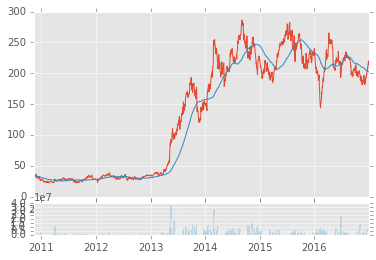

In [26]:
ax1= plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2= plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=1,sharex=ax1)
ax1.plot(df.index,df['Adj Close'])
ax1.plot(df.index,df['100ma'])
ax2.bar(df.index,df['Volume'])

In [35]:
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_volume = df['Volume'].resample('10D').sum()
print(df_ohlc.head())

                 open       high        low      close
Date                                                  
2010-11-17  29.490000  35.470001  29.490000  35.320000
2010-11-27  34.330002  35.330002  30.309999  30.309999
2010-12-07  31.559999  32.369999  28.530001  30.809999
2010-12-17  31.360001  32.630001  30.090000  30.090000
2010-12-27  25.549999  27.730000  25.549999  26.830000


In [36]:
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

In [37]:
df_ohlc.reset_index(inplace=True)
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)

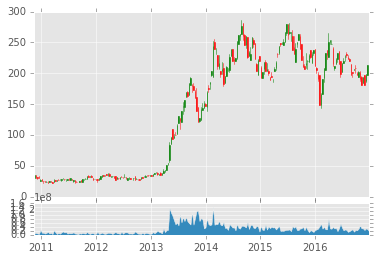

In [38]:
ax1= plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2= plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=1,sharex=ax1)
ax1.xaxis_date()

candlestick_ohlc(ax1,df_ohlc.values,width=2,colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num),df_volume.values,0)

## Getting S&P500 list

In [69]:
import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp=requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup=bs.BeautifulSoup(resp.content,"lxml")
    table = soup.find('table',{'class':'wikitable sortable'})
    tickers=[]
    for row in table.findAll('tr')[1:]:
        ticker=row.findAll('td')[0].text
        tickers.append(ticker)
    
    with open('sp500tickers.pickle','wb') as f:
        pickle.dump(tickers,f)
    
    return tickers

In [75]:
import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web

def get_data_from_yahoo(reload_sp500 = False):
    if reload_sp500:
        tickers=save_sp500_tickers()
    else:
        with open("sp500tickers.pickle","rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
        
    start = dt.datetime(2000,1,1)
    end = dt.datetime(2016,12,31)
    
    for ticker in tickers[:10]:
        print (ticker)
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker,'yahoo',start,end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('Already have {}'.format(ticker))

            
def compile_data():
    with open("sp500tickers.pickle","rb") as f:
        tickers = pickle.load(f)[:10]
        
    main_df = pd.DataFrame()
    for count,ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date',inplace=True)
        df.rename(columns={'Adj Close':ticker},inplace=True)
        df.drop(['Open','High','Low','Close','Volume'],1,inplace=True)
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df,how='outer')
            
        if count % 10 == 0 :
            print(count)
            
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')
compile_data()
    

IOError: File stock_dfs/MMM.csv does not exist

In [76]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
#     df['AAPL'].plot()
#     plt.show()
      df_corr = df.corr()

visualize_data()

IOError: File sp500_joined_closes.csv does not exist